# Introduction

This notebook demonstrates how to:
* Load spectra
* Build the model
* Set boundary conditions
* Fit spectra
* Open fit results and get information from there

In [1]:
# required libraries
from scipy import optimize, signal
from lmfit import models
from functools import reduce
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# custom packages
from libs import datafile, fit

# needed to supress pandas future warnings
import warnings
warnings.simplefilter('ignore')

# Loading spectra

Currently, the package supports *txt files provided by SCIENTA software and *xy files from SPECS Prodigy.
However, it is still possible to import spectra in custom formats.

The *xy files usually contain several scanned regions, and counts are averaged if several sweeps per region were measured.

The *txt files from SCIENTA may contain several sweeps.
It allows us to plot a heatmap and see the stability of the signal.
The averaged counts are still used in the fitting process.

## SPECS prodigy

The class datafile.specs_file(path) is used to read SPECS *xy files.

In [2]:
# load files
specs_Au4f = datafile.specs_file('data/specs/Au4f.xy')
specs_Na1s_Au4f = datafile.specs_file('data/specs/Na1s, Au4f.xy')
specs_S2p = datafile.specs_file('data/specs/S2p.xy')

specs_Au4f.regions

{22: {'region_name': 'Au4f',
  'averaged_spectrum':      energy  raw_counts
  0     90.00  157421.250
  1     89.95  156539.130
  2     89.90  156341.390
  3     89.85  157144.850
  4     89.80  158673.590
  ..      ...         ...
  156   82.20   81105.937
  157   82.15   79451.324
  158   82.10   76262.745
  159   82.05   75058.153
  160   82.00   70869.424
  
  [161 rows x 2 columns],
  'acquisition_date': '02/01/24 18:37:30 UTC+1',
  'analyzer_slit': '3:1x20\\B:open',
  'curves_scan': 1.0,
  'values_curve': 161.0,
  'dwell_time': 0.1,
  'Eph': 350.0,
  'pass_energy': 50.0,
  'bias_voltage': 5.0,
  'detector_voltage': 1915.0,
  'eff_workfunction': 4.37,
  'number_of_scans': 1.0}}

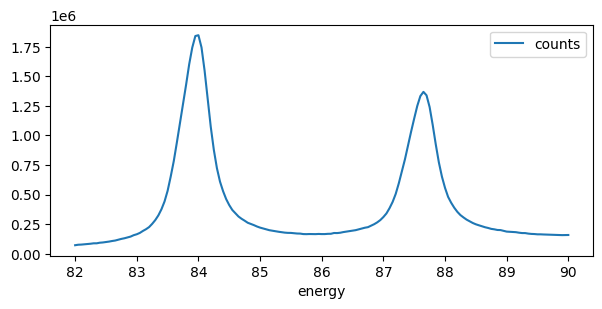

In [3]:
# plot averaged spectrum from chosen region
specs_Au4f.plot_averaged(22);

## SCIENTA

The class datafile.scienta_file(path) is used to read SCIENTA *txt files.

If the file contains several sweeps, they will be averaged.
However, if some of the sweeps need to be excluded, it can be done with <code>reduce_dimension(region_id, exclude = [])</code> method.
The unwanted sweeps will be removed and the averaged counts recalculated.

In [4]:
# load file
scienta_C1s_Au4f = datafile.scienta_file('data/scienta/C1s_Au4f.txt', Eph=500)

Found regions: 2
 C1s_500eV, Au4f_500eV Energy scale: Kinetic, Kinetic


In [5]:
scienta_C1s_Au4f.regions[1].keys()

dict_keys(['region_name', 'energy_scale', 'averaged_spectrum', '2D_spectra'])

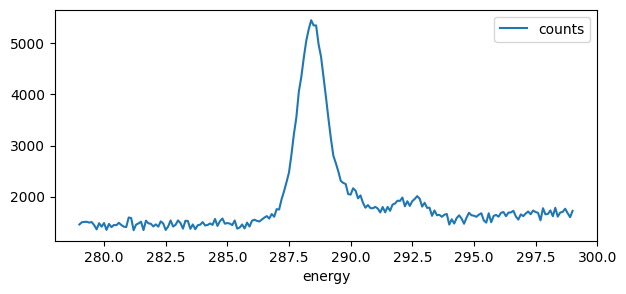

In [6]:
scienta_C1s_Au4f.plot_averaged(1)

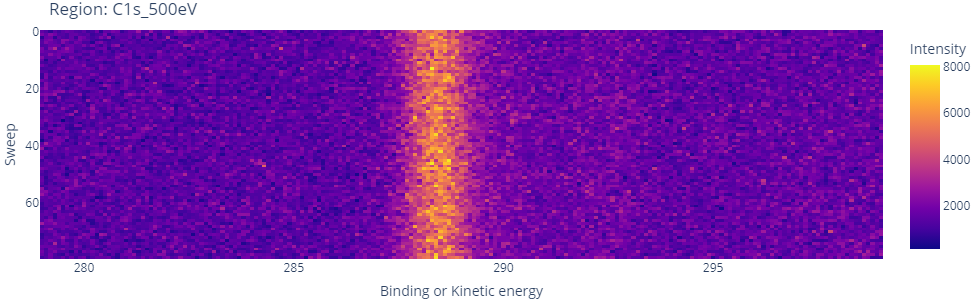

In [7]:
scienta_C1s_Au4f.plot_heatmap(1)

## Custom files

In general, to proceed with fitting, just two arrays are required: one with binding energy scale and one with averaged counts.

Let's consider the case when we have them as an Excel file.

In [8]:
def from_excel(path):
    '''read spectrum from excel file'''
    df = pd.read_excel(path)
    
    # replace , with . if needed
    for col in df.columns:
        try:
            df[col] = df[col].str.replace(',', '.')
        except AttributeError:
            print(f'Column {col} is not a string')

    # convert to float
    df = df.astype('float')
    return df

In [9]:
# use pandas to read excel files
custom_C1s = from_excel('data/excel/C1s.xlsx').astype('float')
custom_S2p = from_excel('data/excel/S2p.xlsx').astype('float')

custom_C1s

Column energy is not a string
Column counts is not a string
Column energy is not a string
Column counts is not a string


energy     counts
0    289.95   9.890218
1    289.90  10.482455
2    289.85  10.678250
3    289.80  10.713324
4    289.75  10.533774
..      ...        ...
202  279.85  10.018411
203  279.80  10.653201
204  279.75  10.864758
205  279.70   9.886599
206  279.65  10.196022

[207 rows x 2 columns]

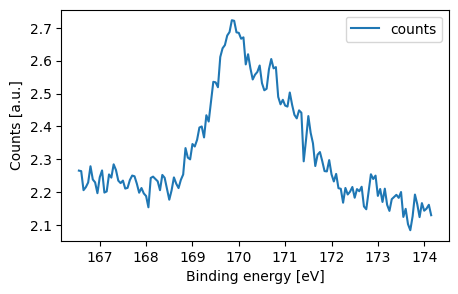

In [10]:
custom_S2p.plot('energy', 'counts', figsize=(5,3), xlabel='Binding energy [eV]', ylabel='Counts [a.u.]');

# Fitting spectra
In XPS spectra, the goal of the fitting is to deconvolute raw counts into individual component peaks corresponding to different chemical species present in the sample. This process involves fitting a model spectrum composed of multiple peaks (each representing a different element or chemical state) to the experimental spectrum. By adjusting parameters such as peak positions, intensities, and widths, the fitting process aims to accurately represent the contributions of various elements and chemical states to the overall XPS spectrum. This allows researchers to quantitatively analyze, for example, the chemical composition and bonding environments of the sample surface.

Here, the  lmfit library is use for fittingd.
Parameter variation and fitting result validation are performed by least-square minimization algorithms.

## Building the model

For XPS spectra fitting, users typically define peak functions based on the expected shape and characteristics of the peaks in their data. Common peak functions used in XPS spectra fitting include Gaussian, Lorentzian, Voigt, or combinations thereof to represent the different types of peaks observed in XPS spectra.

Here is how to implement those peaks and create a model using lmfit library:

In [11]:
# Au 4f spectrum with PseudoVoight peaks
Au4f_peaks = ['Au4f52', 'Au4f12']
Au4f_model = reduce(lambda x, y: x+y, [models.PseudoVoigtModel(prefix=f'{i}_') for i in Au4f_peaks])

In [12]:
# C 1s spectrum with Gaussian peaks
C1s_peaks = ['C1s1', 'C1s2']
C1s_model = reduce(lambda x, y: x+y, [models.GaussianModel(prefix=f'{i}_') for i in C1s_peaks])

In [13]:
# S 2p spectrum with PseudoVoight peaks
S2p_peaks = ['S2p32', 'S2p12']
S2p_model = reduce(lambda x, y: x+y, [models.PseudoVoigtModel(prefix=f'{i}_') for i in S2p_peaks])

## Setting initial guess and boundary conditions

Setting initial guesses and boundary conditions in the context of fitting XPS spectra, or any other type of spectral data, is crucial for obtaining accurate and reliable results from the fitting process for several reasons:

* The fitting algorithm used to optimize the parameters of the model needs a starting point to begin the optimization process. Setting initial guesses provides this starting point and helps the algorithm converge to a solution more efficiently. Without reasonable initial guesses, the algorithm may struggle to converge or converge to a suboptimal solution.
* Sometimes fitting algorithms can get trapped in local minima, especially if the parameter space is complex or the model is highly nonlinear. Setting initial guesses closer to the true values helps the algorithm avoid such local minima and converge to the global minimum, leading to a more accurate fit.
* In many cases, the parameters being fitted have physical meaning and should fall within certain boundaries. For example, in XPS spectra fitting, peak positions cannot be negative and peak widths should be positive. Setting boundary conditions ensures that the fitted parameters remain physically meaningful and realistic.
* Providing reasonable initial guesses and boundary conditions can significantly improve the speed of convergence of the fitting algorithm. This is particularly important when dealing with large datasets or when performing iterative fitting procedures.

Besides that, spectra often contain overlapping peaks or have a low signal-to-noise ratio. In such cases, proper signal decomposition is impossible without any preliminary knowledge.

Here is how to set up initial guess and boundary conditions:

In [14]:
# Au 4f spectra
positions = [84.0, 87.7]
amplitudes = [2e9, 1.5e9]

Au4f_params = Au4f_model.make_params()

for i, val in enumerate(Au4f_peaks):
    Au4f_params.add(f'{val}_center', value=positions[i])
    Au4f_params.add(f'{val}_amplitude', value=amplitudes[i])

In [15]:
# C 1s spectra
positions = [288, 292]
amplitudes = [5e3, 1e3]

C1s_params = C1s_model.make_params()

for i, val in enumerate(C1s_peaks):
    C1s_params.add(f'{val}_center', value=positions[i])
    C1s_params.add(f'{val}_amplitude', value=amplitudes[i])

2p orbitals may have specific peak splitting. In case of S 2p:

In [16]:
# S 2p spectra
S2p_params = S2p_model.make_params()

# main peak boundaries
S2p_params.add('S2p32_center', min=169, value=170, max=171)
S2p_params.add('S2p32_amplitude', min=0, value=1)
S2p_params.add('S2p32_sigma', value=.5, max=.8) # limit width
S2p_params.add('S2p32_fraction', min=0, value=0, max=.1) # Gaussian/Lorentian ratio

# dependent peak
S2p_params.add('S2p12_center', expr=f'S2p32_center + 1.16') # fix binding energy shift
S2p_params.add('S2p12_amplitude', expr=f'S2p32_amplitude * 0.511') # fix height ratio
S2p_params.add('S2p12_sigma', expr=f'S2p32_sigma') # force same width
S2p_params.add('S2p12_fraction', expr=f'S2p32_fraction') # force same Gaussian/Lorentian ratio

## Signal background

In XPS, the background refers to the signal that arises from sources other than the photoelectron emissions of interest. This background signal can originate from various sources such as inelastic scattering of photoelectrons within the sample, secondary electron emissions, or instrumental artifacts.

Background subtraction is a critical step in XPS data analysis to isolate the signal from the sample's surface chemistry. Typically, this is done by fitting a smooth mathematical function to regions of the spectrum where no significant photoelectron peaks are present, such as the low-energy tail or high-energy regions. The fitted background function is then subtracted from the entire spectrum to remove the background signal, leaving behind the photoelectron peaks for further analysis.Here, three types of backgrounds are implemented:
1. Shirley - fit.get_shirley()
2. Tougaard - fit.get_tougaard()
3. ALS - baseline correction using asymmetrically reweighted penalized least squares smoothing, fit.baseline_als()

The most accepted type is Shirley background. sis.

## Fit and save

In general, it's better to have model parameters (initial guess and boundary conditions) in a same cell as the fitting part of the code since the parameters may slightly vary from one spectrum to another even if they are from the same orbital.

### Au 4f spectrum from SPECS

In [17]:
# check region indexes
specs_Au4f.regions.keys()

dict_keys([22])

center  position_err         area   area_err      height  fwhm
Au4f52   83.95           0.0  26436089.74  945737.93  1746550.41  0.56
Au4f12   87.62           0.0  19209313.29  966183.86  1219767.27  0.58

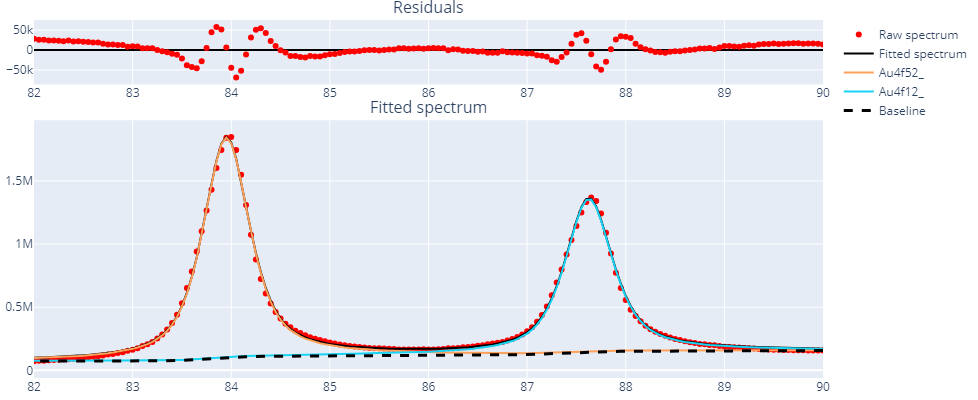

In [18]:
region = 22
name = 'specs_Au4f_fitting'

# sometime fitting works better if you cut the range
x_cut, y_cut = fit.cut_range(specs_Au4f, region, cut_range=None)

# get Shirley background
bkg = fit.get_shirley(x_cut, y_cut, window_size=5)

# get and plot fitting results
results = fit.fit_results(x_cut, y_cut, bkg, Au4f_model, Au4f_params, name)
results.plot_results()

# save fitting in ./fits folder
results.export_json(name);

Residuals here are non-ideal because in general Au 4f spectra contain contribution from bulk and surface, and the signal should be fit with four peaks.

### S 2p spectrum from custom file

In [19]:
custom_S2p.head()

energy    counts
0  174.15  2.130106
1  174.10  2.161794
2  174.05  2.150127
3  174.00  2.143857
4  173.95  2.166929

center  position_err   area  area_err  height  fwhm
S2p32  169.96          0.02  16.10      6.31    0.54  1.37
S2p12  171.12          0.02   8.23      3.21    0.28  1.37

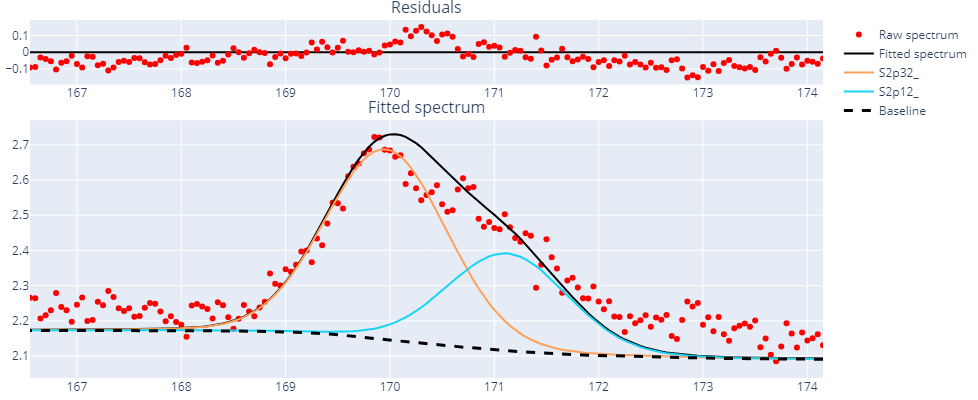

In [20]:
name = 'custom_S2p_fitting'

# get x and y for fitting
x = np.array(custom_S2p.energy)
y = np.array(custom_S2p.counts)

# get Shirley background
bkg = fit.get_shirley(x, y, window_size=5)

# get and plot fitting results
results = fit.fit_results(x, y, bkg, S2p_model, S2p_params, name)
results.plot_results()

# save fitting in ./fits folder
results.export_json(name);

### C 1s spectrum from SCIENTA

center  position_err      area  area_err   height  fwhm
C1s1  288.44          0.01  51568.06   3416.23  3662.52  1.32
C1s2  290.90          0.24  35526.82   8378.09   353.28  9.70

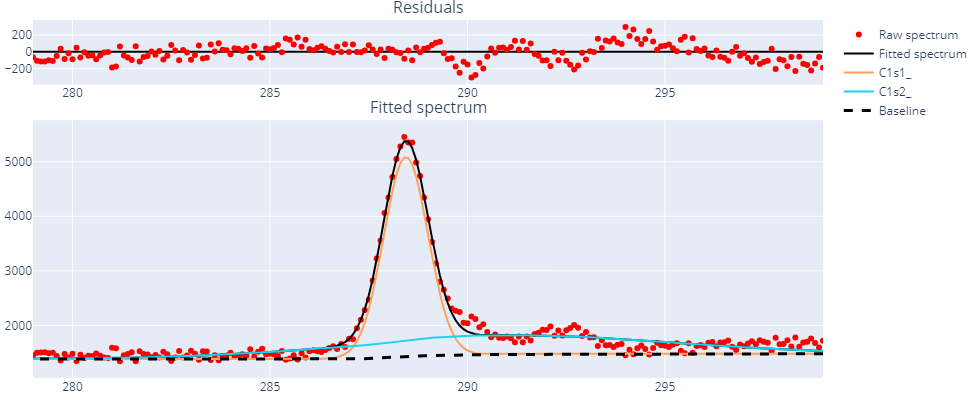

In [21]:
region = 1
name = 'scienta_C1s_fitting'

# sometime fitting works better if you cut the range
x_cut, y_cut = fit.cut_range(scienta_C1s_Au4f, region, cut_range=None)

# get Shirley background
bkg = fit.get_shirley(x_cut, y_cut, window_size=5)

# get and plot fitting results
results = fit.fit_results(x_cut, y_cut, bkg, C1s_model, C1s_params, name)
results.plot_results()

# save fitting in ./fits folder
results.export_json(name);

Here we see that the first peak looks fine, however second one is too broad. Besides that, we see a small bump near the largest peak that may be another species. The issue with the background can be solved by narrowing the energy range. Let's take all mentioned into account and make another attempt to fit:

center  position_err      area  area_err   height  fwhm
C1s1  288.43          0.01  58256.64   3053.16  3917.64   1.4
C1s2  290.26          0.06   7859.12   2509.91   528.51   1.4
C1s3  292.43          0.05   7763.50   2188.67   522.08   1.4

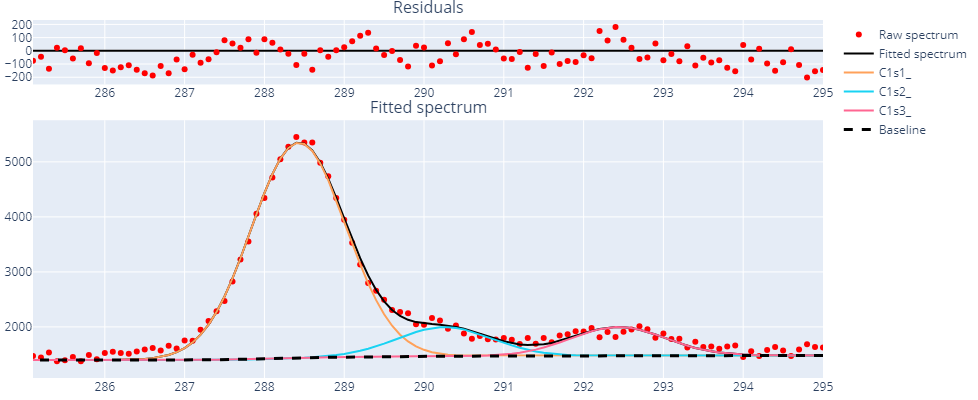

In [22]:
# update the model
C1s_peaks = ['C1s1', 'C1s2', 'C1s3']
C1s_model = reduce(lambda x, y: x+y, [models.GaussianModel(prefix=f'{i}_') for i in C1s_peaks])

# update parameters
positions = [288.4, 290.4, 292.6]
amplitudes = [5e3, 2e3, 2e3]

C1s_params = C1s_model.make_params()

for i, val in enumerate(C1s_peaks):
    C1s_params.add(f'{val}_center', value=positions[i])
    C1s_params.add(f'{val}_amplitude', value=amplitudes[i])

# force widths to be equal
C1s_params.add('C1s2_sigma', expr=f'C1s1_sigma')
C1s_params.add('C1s3_sigma', expr=f'C1s1_sigma')

region = 1
name = 'new_scienta_C1s_fitting'

# cut binding energy scale
x_cut, y_cut = fit.cut_range(scienta_C1s_Au4f, region, cut_range=[285, 295])

# get Shirley background
bkg = fit.get_shirley(x_cut, y_cut, window_size=5)

# get and plot fitting results
results = fit.fit_results(x_cut, y_cut, bkg, C1s_model, C1s_params, name)
results.plot_results()

# save fitting in ./fits folder
results.export_json(name);

Looks much better!

# Get data from fit

Let's try to get information about the peak from fitting results. Fitted C 1s spectrum will be used.

In [23]:
def get_param(name, param, peak):
    '''get parameter from fitted file
    '''
    # name = name.replace(' ', '')
    with open('fits/' + name + '.json') as f:
        try:
            return json.load(f)['displayed_results'][param][peak]
        except KeyError as e:
            print(e)
            raise Exception(f'Something is wrong with {name}')

In [24]:
name = 'new_scienta_C1s_fitting'
peak = 'C1s1'
print(f'''
Summary on the first peak in C 1s spectrum:
Area \t\t {get_param(name, 'area', peak):.2f} a.u.
Binding energy \t {get_param(name, 'center', peak):.2f} eV
FWHM \t\t {get_param(name, 'fwhm', peak):.2f} eV
''')


Summary on the first peak in C 1s spectrum:
Area 		 58256.64 a.u.
Binding energy 	 288.43 eV
FWHM 		 1.40 eV



# What's next

More information on peak fitting can be found in lmfit documentation. 